In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
songs = pd.read_csv('./data/five_genres_500_samp.csv')

In [220]:
X = songs._get_numeric_data().drop(columns=['key', 'mode'])
y = songs['genre']

In [71]:
def running_models(X, y):
    # Our features from Spotify are scaled between 0 and 1 already, so we don't need to transform them
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)
    model_df = pd.DataFrame(columns=['train_score', 'test_score'])
    
    model = SVC(C=10000, kernel='rbf')
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    row = {'model': type(model).__name__,
           'train_score' : train_score,
          'test_score' : test_score}
    model_df = model_df.append(row, ignore_index=True)
    return model_df
    
    

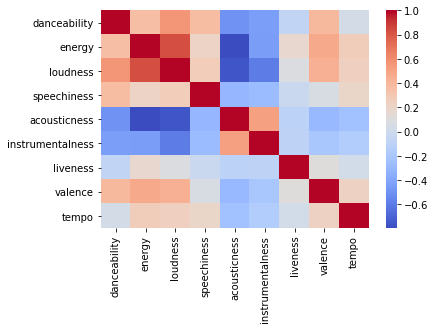

In [173]:
sns.heatmap(results.corr(), cmap='coolwarm');

There's a high **positive correlation between loudness and energy** and a high **negative correlation between energy and acousticness**

In [72]:
running_models(X, y)

,train_score,test_score,model
0,0.757333,0.7632,SVC


In [ ]:
RandomForestClassifier()

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

In [138]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [160]:
# .76
model = SVC(1, kernel='rbf')

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass C=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [161]:
model.fit(X_train_sc, y_train)

SVC(C=1)

In [162]:
model.score(X_train_sc, y_train)

0.7984

In [163]:
model.score(X_test_sc, y_test)

0.7696

In [164]:
y_preds = model.predict(X_test_sc)

In [165]:
results = X_test.copy()

In [166]:
results.loc[:, 'genre'] = y_test.copy()

In [167]:
results.loc[:, 'preds'] = y_preds.copy()

In [168]:
results_wrong = results[results['genre'] != results['preds']]

In [169]:
results_wrong['genre'].value_counts(normalize=True)

rap                      0.319444
r&b                      0.263889
rock                     0.201389
progressive bluegrass    0.131944
classical                0.083333
Name: genre, dtype: float64

Rap and R&B seem to be predicted wrong most often based on the features Spotify has pulled from the music.

In [170]:
results_wrong[results_wrong['genre'] == 'rap']['preds'].value_counts(normalize=True)

r&b                      0.891304
rock                     0.043478
progressive bluegrass    0.043478
classical                0.021739
Name: preds, dtype: float64

It seems that when Rap is predicted wrong, it's predicted as R&B about 89.1% of the time

In [171]:
results_wrong[results_wrong['genre'] == 'r&b']['preds'].value_counts(normalize=True)

rap                      0.473684
rock                     0.236842
progressive bluegrass    0.236842
classical                0.052632
Name: preds, dtype: float64

R&B is most likely to be predicted as rap, but only 47.3% of the time.

In [199]:
genre_mean = songs.groupby('genre').mean()

Text(0.5, 1.0, 'Danceability by Genre')

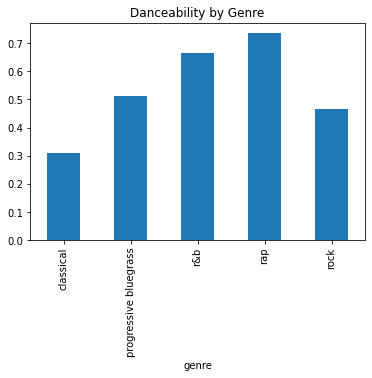

In [200]:
genre_mean['danceability'].plot(kind='bar');
plt.title('Danceability by Genre')

It looks like Rap has the highest danceability at over 0.7, Classical has the lowest danceability at just above 0.3.

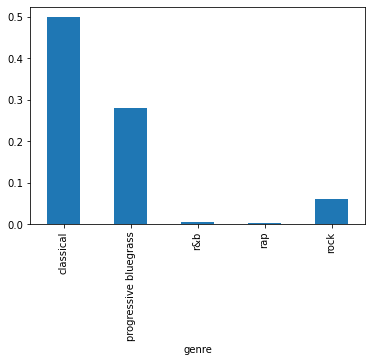

In [204]:
genre_mean['instrumentalness'].plot(kind='bar');

Classical has the highest instrumentalness, while rap has the lowest

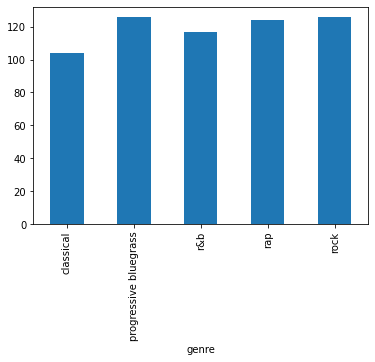

In [205]:
genre_mean['tempo'].plot(kind='bar');

Interesting that most of the genres hover slightly above 120 as a tempo. There's some interesting reasoning behind this with commercial music and the need for 30-seconds of music to fill an advertising slot. 128 beats per minute would allow for a 16-bar phrase in 4/4 time.

In [237]:
X = songs._get_numeric_data().drop(columns=['key', 'mode'])
# Thanks joris on SO: https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe/32011969
y_cat = songs['genre'].astype('category').cat.codes

In [238]:
y = to_categorical(y_cat)

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

In [240]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [260]:
fnn_model = Sequential()

fnn_model.add(Dense(9, activation='relu', input_shape=(X_train_sc.shape[1],)))
fnn_model.add(Dense(32, activation='relu'))
fnn_model.add(Dropout(0.2))
fnn_model.add(Dense(16, activation='relu'))
fnn_model.add(Dense(5, activation='softmax'))

fnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

hist = fnn_model.fit(X_train_sc, y_train,
                epochs=500,
                batch_size=128,
                validation_data=(X_test_sc, y_test),
                    use_multiprocessing=True,
                    verbose=0)

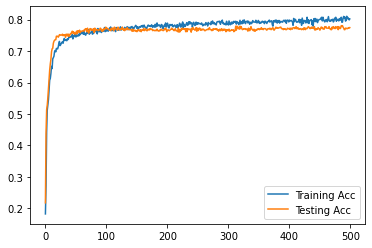

In [263]:
plt.plot(hist.history['acc'], label="Training Acc")
plt.plot(hist.history['val_acc'], label="Testing Acc")
plt.legend();

I don't seem to be able to get higher than **77% accuracy** with the features Spotify provides, even with a Feedforward Neural Network

## What's next?

Now that I've seen how accurate models can be with the features that Spotify provides, I want to create/extract my own features from the audio I've pulled from Spotify.